### Note: Just started hacking on this, the code is a mess =D

---

# Comparing Estimators on a few toy datasets
Inspired by this excellent sample from sklearn: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

Create a few toy datasets. 'Blobs' is linearly seperable, the others are not.

In [2]:
datasets = []
n_samples = 100
datasets.append(('Blobs', make_blobs(n_samples=n_samples, centers=2, cluster_std=0.5, random_state=0)))
datasets.append(('Circles', make_circles(n_samples=n_samples, factor=.5, noise=.03, random_state=0)))
datasets.append(('Moons', (make_moons(n_samples=n_samples, noise=.03, random_state=0))))

Plot them.

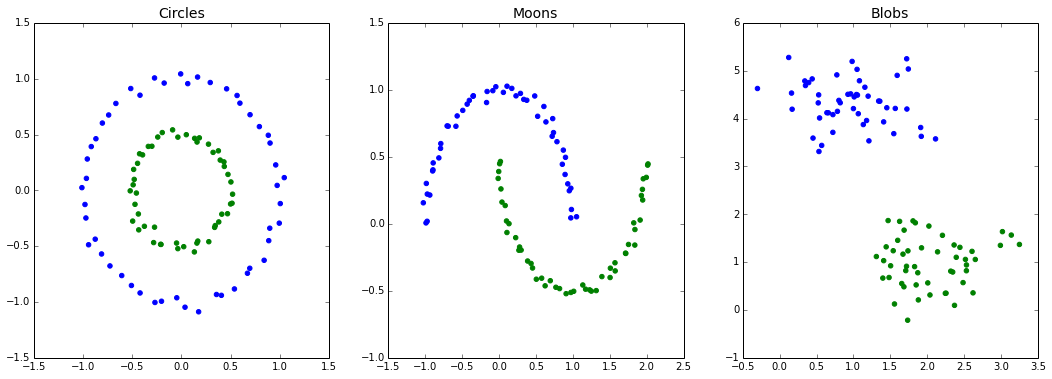

In [8]:
figure = plt.figure(figsize=(18, 6))
colors = np.array(["blue", "green"])
for i in range(len(datasets)):
    name, (X,y) = datasets[i]
    ax = plt.subplot(1, len(datasets), i)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y].tolist())
    plt.title(name, fontsize=14)
plt.show()

Create a few Estimators. Or at least, create them once the feature cols are available.

In [4]:
n_estimators = 2

def make_estimators(feature_cols, n_classes):

    estimators = []

    estimators.append(('Linear',
        tf.estimator.LinearClassifier(
            feature_columns=feature_cols, 
            n_classes=n_classes,
            model_dir="./graphs/canned/linear"
        ))
    )

    estimators.append(('Deep',
        tf.estimator.DNNClassifier(
            hidden_units=[128, 128],
            feature_columns=feature_cols,
            n_classes=n_classes,
            model_dir="./graphs/canned/deep"
        ))
    )
    
    return estimators

Calling predict on an estimator returns a generator object. For convenience, this method will give us a list of predictions.

In [9]:
def get_predictions(estimator, input_fn):
    predictions = []
    for prediction in estimator.predict(input_fn=input_fn):
        probs = prediction['probabilities']
        cls = np.argmax(probs)
        predictions.append(cls)
    return predictions

Train / evaluate the Estimators on each dataset, and plot the decision boundaries.

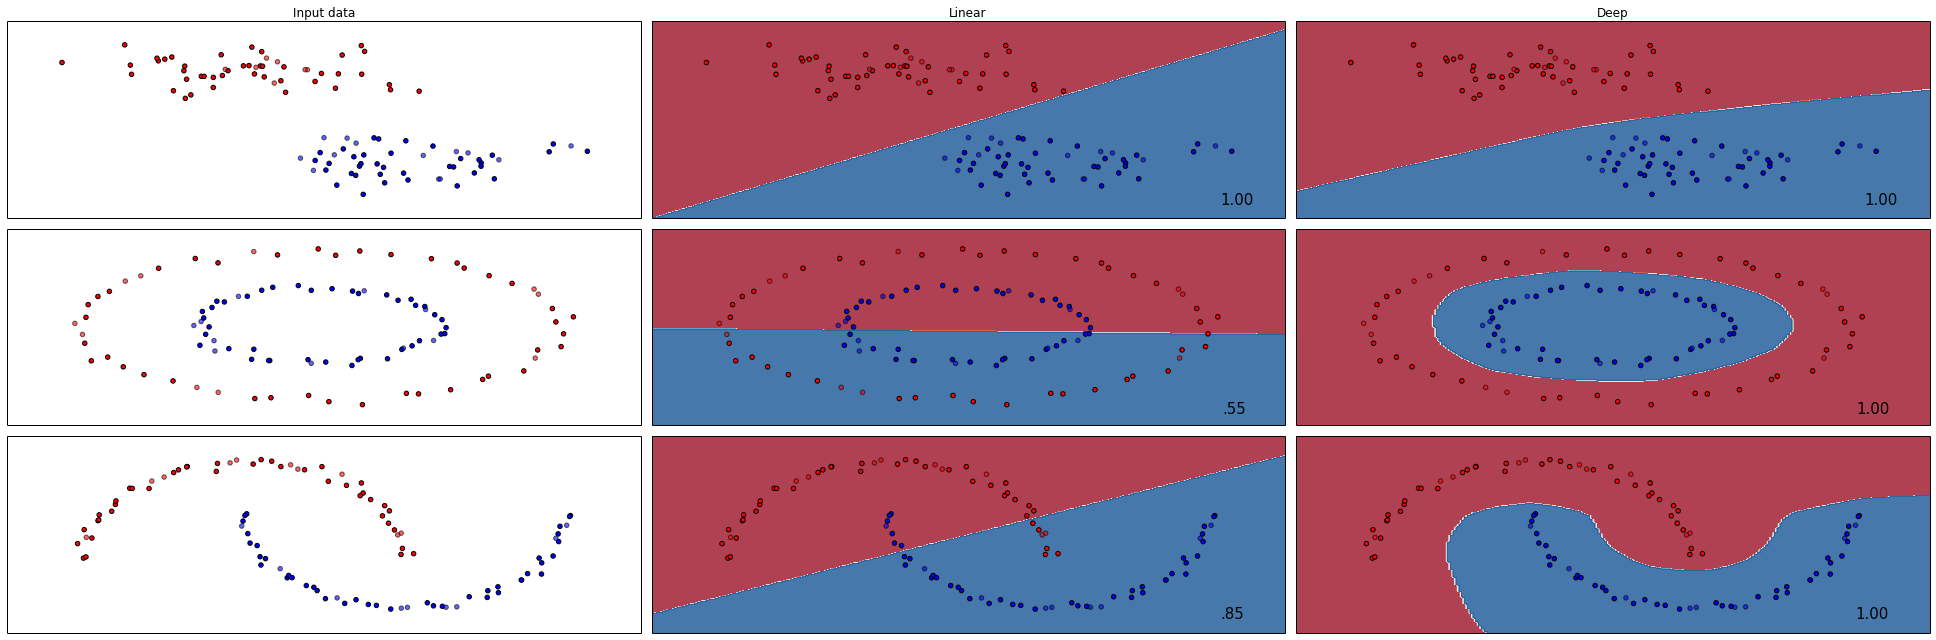

In [7]:
tf.logging.set_verbosity(tf.logging.ERROR)

figure = plt.figure(figsize=(27, 9))
i = 1

for ds_cnt, dataset in enumerate(datasets):

    name, (X, y) = dataset
    
    # Standardize values to 0 mean and unit standard deviation
    X = StandardScaler().fit_transform(X)
    
    # Split in to train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
    # Step size in the mesh
    h = .02  

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the dataset
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), n_estimators + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
        
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    n_features = len(X_train[2])
    n_classes = len(np.unique(y_train))
    feature_cols = [tf.feature_column.numeric_column('x', shape=n_features)]
    
    for name, estimator in make_estimators(feature_cols, n_classes):
        
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            {'x': X_train},
            y_train, 
            num_epochs=None, # Repeat forever
            shuffle=True
        )

        test_input_fn = tf.estimator.inputs.numpy_input_fn(
            {'x': X_test},
            y_test, 
            num_epochs=1, # Repeat forever
            shuffle=False
        )
        
        # An input function for each point on the mes
        surface_input_fn = tf.estimator.inputs.numpy_input_fn(
            {'x': np.c_[xx.ravel(), yy.ravel()]},
            num_epochs=1, # Repeat forever
            shuffle=False
        )
        
        estimator.train(train_input_fn, steps=100)
        evaluation = estimator.evaluate(test_input_fn)
        accuracy = evaluation["accuracy"]
        
        ax = plt.subplot(len(datasets), n_estimators + 1, i)
        
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max]. 
        Z = np.array(get_predictions(estimator, input_fn=surface_input_fn))

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % accuracy).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
        
plt.tight_layout()
plt.show()